In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
plt.style.use('ggplot')

In [31]:
df_train = pd.read_csv('input/sales_train.csv')
df_test = pd.read_csv("input/test.csv")
df_categories = pd.read_csv("input/item_categories.csv")
df_items = pd.read_csv("input/items.csv")
df_shops = pd.read_csv("input/shops.csv")

In [32]:
df_train.drop_duplicates(['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day'], keep='first',
                         inplace=True)  # remove duplicates
df_train = df_train[(df_train.item_price < 300000)]  # remove price outliers
df_train.date = pd.to_datetime(df_train.date)

In [33]:
df_train_pivot = pd.pivot_table(df_train, values=['item_cnt_day'], index=['shop_id', 'item_id'],
                                columns=['date_block_num'],
                                aggfunc=sum).fillna(0)

df_train_pivot.columns = [col[1] for col in df_train_pivot.columns]
df_train_pivot = df_train_pivot.reset_index()

print(df_train_pivot.head())

   shop_id  item_id    0     1    2    3    4    5    6    7  ...   24   25  \
0        0       30  0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1        0       31  0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2        0       32  6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3        0       33  3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4        0       35  1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    26   27   28   29   30   31   32   33  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]


In [47]:
from sklearn.model_selection import train_test_split

X = df_train_pivot.drop(columns=[33, "shop_id", "item_id"])
y = df_train_pivot[33]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=1, shuffle=False)

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))


In [51]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,284162.0,2.150417e-17,1.000002,-8.641912,-0.217234,-0.217234,-0.217234,109.303586
1,284162.0,-2.800543e-18,1.000002,-2.562063,-0.199013,-0.199013,-0.199013,68.920200
2,284162.0,2.665517e-17,1.000002,-1.092138,-0.161936,-0.161936,-0.161936,120.299170
3,284162.0,-1.185230e-17,1.000002,-1.609797,-0.179881,-0.179881,-0.179881,124.937790
4,284162.0,6.701299e-18,1.000002,-0.604970,-0.120098,-0.120098,-0.120098,244.255658
5,284162.0,3.400659e-18,1.000002,-0.382320,-0.085166,-0.085166,-0.085166,227.535085
6,284162.0,-1.744088e-18,1.000002,-0.811003,-0.095512,-0.095512,-0.095512,285.743362
7,284162.0,-2.680520e-17,1.000002,-0.748792,-0.094353,-0.094353,-0.094353,268.225845
8,284162.0,-4.075790e-18,1.000002,-0.309546,-0.074208,-0.074208,-0.074208,223.497047
9,284162.0,2.650514e-18,1.000002,-0.357946,-0.083479,-0.083479,-0.083479,268.345002


In [52]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_val.shape)

Train set reshaped (284162, 33, 1)
Validation set reshaped (139961, 33, 1)


In [43]:
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout

In [71]:
serie_size =  X_train.shape[1] 
n_features =  X_train.shape[2]

epochs = 10
batch = 64*4

lstm_model = Sequential()
lstm_model.add(LSTM(15,input_shape = (33,1),return_sequences=True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(60))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1))

lstm_model.compile(loss = 'mse',optimizer = 'adam')
lstm_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 33, 15)            1020      
_________________________________________________________________
dropout_14 (Dropout)         (None, 33, 15)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 60)                18240     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 61        
Total params: 19,321
Trainable params: 19,321
Non-trainable params: 0
_________________________________________________________________


In [72]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_val, y_val), verbose=2)

Train on 284162 samples, validate on 139961 samples
Epoch 1/1
 - 173s - loss: 22.3796 - val_loss: 2.2668


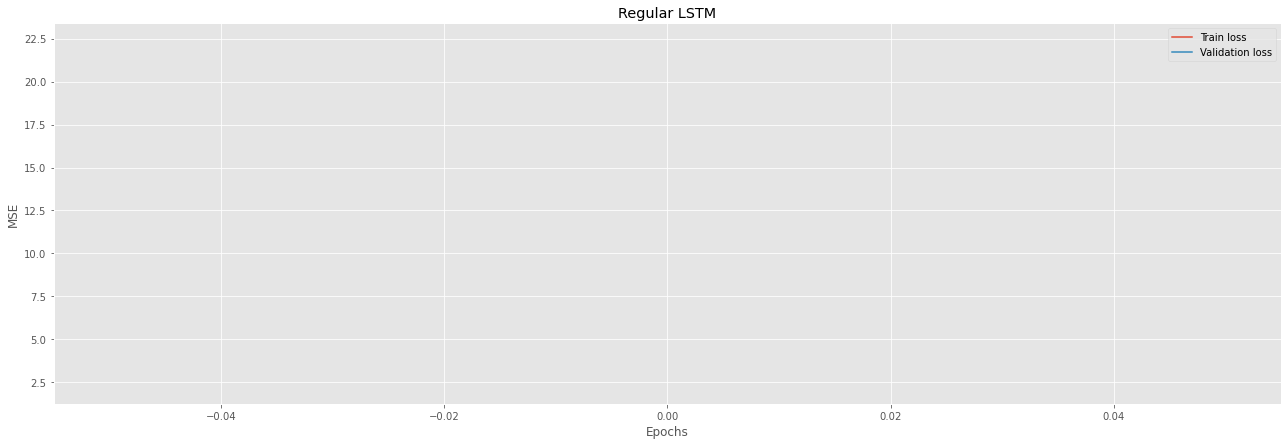

In [73]:
fig, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

plt.show()

In [23]:
df_test_pivot = pd.merge(df_test, df_train_pivot, on=['item_id', 'shop_id'], how='left').fillna(0)
df_test_pivot = df_test_pivot.drop(columns=["ID"])
X_test = df_test_pivot.drop(columns=0)

X_test.columns = X.columns

X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print("Test set reshaped", X_train.shape)

Test set reshaped (284162, 35, 1)


In [24]:
prediction_test = lstm_model.predict(X_test)

In [28]:
output = pd.DataFrame({"ID": df_test["ID"], "item_cnt_month": prediction_test.ravel().clip(0, 20)})
output.to_csv("output/submission4.csv",index=False)